# Пример экстраполяции FFT для TL Sales

In [43]:
import pandas as pd
import numpy as np
from numpy import pi
import pylab as pl
from numpy import fft
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.ticker import MultipleLocator
%matplotlib inline

In [88]:
def fourierExtrapolation(x, n_predict, n_harm=10):
    n = x.size
    #n_harm = 15                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    
    indexes.sort(key = lambda i: np.absolute(f[i])) # sort indexes by frequency, lower -> higher
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [12]:
# загрузка в датафрейм
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv("TL_Sales.csv", delimiter=";", index_col='DATE', date_parser=dateparse)
sales_df.index = pd.to_datetime(sales_df.index)

In [13]:
sales_df.head()

,Sales,Forecast_2018.09,Forecast_2017.12
DATE,,,
2008-01-09,135255.98,NaN,NaN
2008-01-10,113545.22,NaN,NaN
2008-01-11,196789.35,NaN,NaN
2008-01-14,225619.71,NaN,NaN
2008-01-15,436096.72,NaN,NaN


In [242]:
# входные данные для фиттинга до 30.09.2018
train = sales_df.Sales[:'2018-01-30'].dropna().resample('MS').agg(sum)['2015':]
test = sales_df.Sales['2018-01-01':'2018-09-30'].dropna().resample('MS').agg(sum)

In [243]:
forecast_horizon = 12
harmonics = 15
x = np.array(train.tolist()) # входные данные для FFT-экстраполяции
extrapolation = fourierExtrapolation(x, forecast_horizon, n_harm=harmonics)

In [244]:
time_range = pd.date_range(start=train.index[0], periods=len(train)+forecast_horizon, freq='MS')

# строим прогноз
forecast = pd.DataFrame(list(zip(time_range, extrapolation)), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

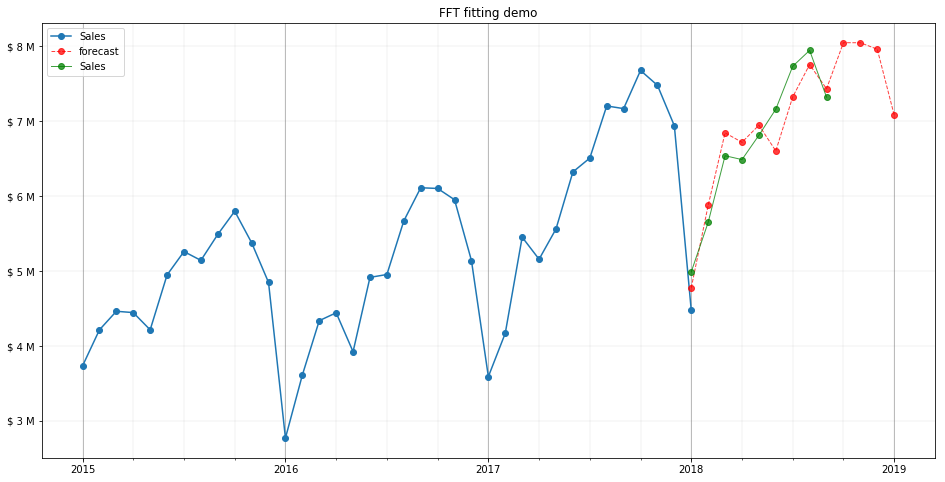

In [246]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
ax = plt.gca()

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "$ {:,.0f} M".format(int(x)/1e6)))
ax.yaxis.grid(which='major', color='gray', linewidth=0.1)

ax.xaxis.set_major_locator(dates.YearLocator(1))
ax.xaxis.set_minor_locator(dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))

ax.xaxis.grid(which='major', color='gray', linewidth=0.5)
ax.xaxis.grid(which='minor', color='gray', linewidth=0.1)

train.plot(ax=ax, marker='o', title=f"FFT fitting demo")
forecast['2018':].plot(color='red', linewidth=1, linestyle='--', marker='o', alpha=0.75, ax=ax)
test.plot(color='green', linewidth=1, linestyle='-', marker='o', alpha=0.75, ax=ax)
ax.grid(True)

#plt.setp(ax.xaxis.get_majorticklabels(), position=(0,0.04), rotation=0, ha="left")
plt.legend()
ax.set(xlabel='')
plt.show()